First we must import the following packages

In [2]:
# matplotlib inline
import datetime
import datetime
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas_datareader import data as web
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller

Next we Load the Data

In [5]:
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2019, 2, 1)

In [6]:
price = web.DataReader('BABA', 'yahoo', start, end)['Close']
price.index = pd.to_datetime(price.index)

Next we do some plots to take a look at the data. 

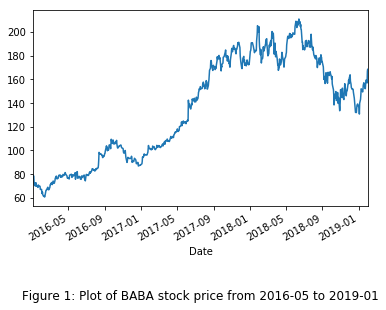

In [7]:
plt.title('Figure 1: Plot of BABA stock price from 2016-05 to 2019-01', y=-.51)
price.plot()

Figure 1: Plot of BABA stock price from 2016-05 to 2019-01.

Date
2016-01-04    76.690002
2016-01-05    78.629997
2016-01-06    77.330002
2016-01-07    72.720001
2016-01-08    70.800003
Name: Close, dtype: float64


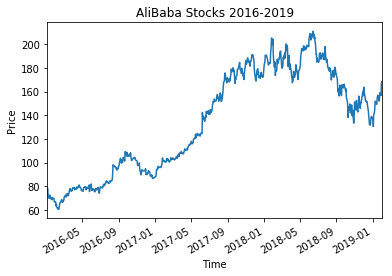

<bound method NDFrame.describe of                   High         Low        Open       Close    Volume  \
Date                                                                   
2016-01-04   78.309998   75.180000   78.180000   76.690002  23066300   
2016-01-05   78.680000   77.260002   77.919998   78.629997  14258900   
2016-01-06   78.485001   76.970001   77.120003   77.330002  11569300   
2016-01-07   75.500000   71.540001   73.290001   72.720001  27288100   
2016-01-08   74.660004   70.669998   74.330002   70.800003  20814600   
2016-01-11   71.730003   69.019997   71.290001   69.919998  16961400   
2016-01-12   72.769997   71.000000   71.449997   72.680000  13456000   
2016-01-13   73.238998   70.220001   72.769997   70.290001  12480200   
2016-01-14   72.720001   68.269997   70.290001   72.250000  17719600   
2016-01-15   71.000000   67.541000   68.699997   69.589996  20722500   
2016-01-19   72.309998   69.809998   71.940002   70.129997  17421700   
2016-01-20   69.112000   65.33

In [8]:
# price = web.DataReader('BABA', 'yahoo', start, end)
# price.index = pd.to_datetime(price.index)
#
#
# # data = read_csv('AirPassengers.csv',sep=',')
data = web.DataReader('BABA', 'yahoo', start, end)
stock_price = data['Close']
data.index = pd.to_datetime(data.index)
print(stock_price.head())
fig = plt.figure()

stock_price.plot()
plt.title("AliBaba Stocks 2016-2019")
plt.xlabel("Time")
plt.ylabel('Price')
plt.show()

data.describe

Data with Rolling Mean removed

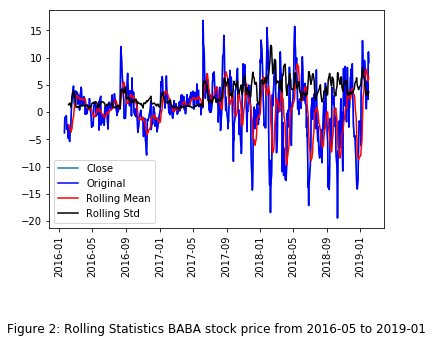

Results of Dickey-Fuller Test:
Test Statistic                  -5.430125
p-value                          0.000003
#Lags Used                      11.000000
Number of Observations Used    753.000000
Critical Value (1%)             -3.439064
Critical Value (5%)             -2.865386
Critical Value (10%)            -2.568818
dtype: float64


In [15]:
moving_avg = stock_price.rolling(12).mean()
no_trend = stock_price - moving_avg
plt.plot(no_trend)
plt.title("Passenger Data with Rolling Mean Removed")
test_stationarity(no_trend.dropna())

We log-transform the data to make it stationary

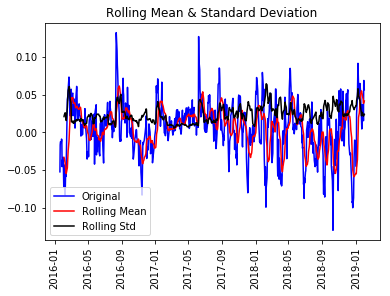

Results of Dickey-Fuller Test:
Test Statistic                  -5.448423
p-value                          0.000003
#Lags Used                      11.000000
Number of Observations Used    753.000000
Critical Value (1%)             -3.439064
Critical Value (5%)             -2.865386
Critical Value (10%)            -2.568818
dtype: float64


In [18]:
import numpy as np
log_stock_price=np.log(stock_price)
log_moving_avg = log_stock_price.rolling(12).mean()
log_no_trend=log_stock_price - log_moving_avg
test_stationarity(log_no_trend.dropna())

Next we plot the data further to show trends

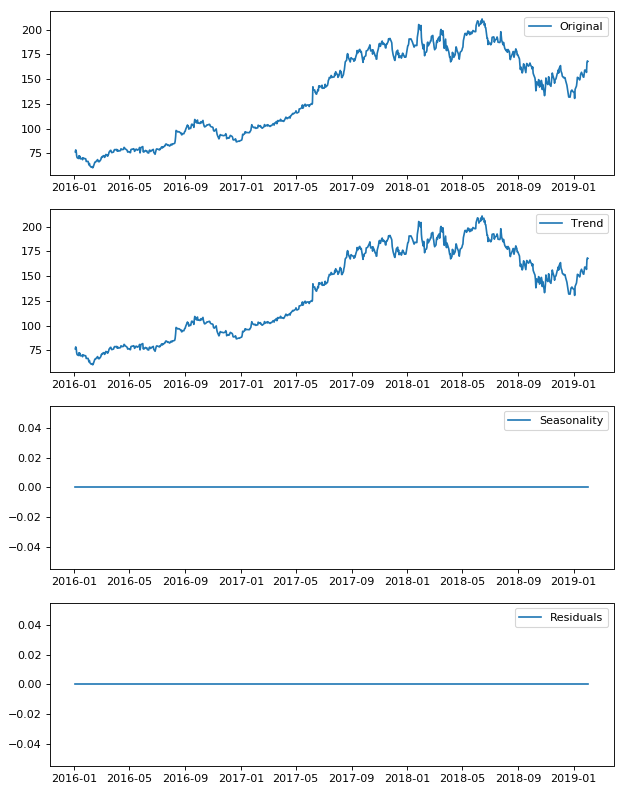

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(stock_price,freq=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(num=None, figsize=(8, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(411)
plt.plot(stock_price, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Next we create a function called `test_stationary` to create our timeseries data. 

In [17]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.xticks(rotation=90)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')

    plt.show(block=False)
    

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

Next we will try some differencing to try and eliminate seasonality and make the series further staionary. This determines if we use a difference term or not. In this example, 1 shift ( 𝑦𝑡−𝑦𝑡−1 ) is used, so d=1

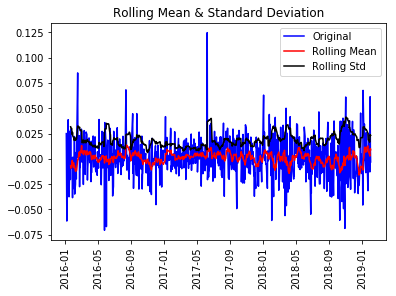

Results of Dickey-Fuller Test:
Test Statistic                -1.039684e+01
p-value                        1.955228e-18
#Lags Used                     7.000000e+00
Number of Observations Used    7.670000e+02
Critical Value (1%)           -3.438905e+00
Critical Value (5%)           -2.865316e+00
Critical Value (10%)          -2.568781e+00
dtype: float64


In [32]:
diff_stock_price = log_stock_price-log_stock_price.shift()
test_stationarity(diff_stock_price.dropna())

In [ ]:
Now we create some auto-correlation plots

Text(0.5, 1.0, 'Autocorrelation Function')

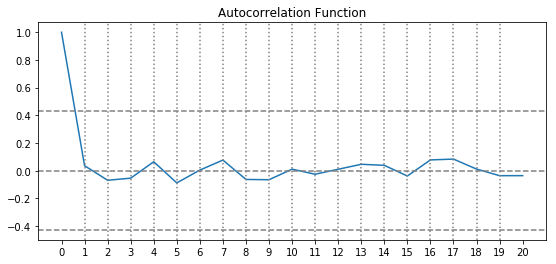

In [35]:
from statsmodels.tsa.stattools import acf, pacf
acf_stock_plot = acf(diff_stock_price.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_stock_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_stock_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_stock_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

We also try a partial ACF

Text(0.5, 1.0, 'Partial Autocorrelation Function')

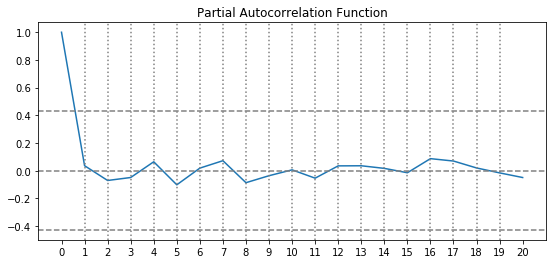

In [39]:
pacf_stock_price = pacf(diff_stock_price.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_stock_price)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_stock_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_stock_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function')

We now fit Arima Model to the data

In [36]:
from statsmodels.tsa.arima_model import ARIMA
diff_stock_price = log_stock_price-log_stock_price.shift()
model = ARIMA(diff_stock_price.dropna(), order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

D:\Programs\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

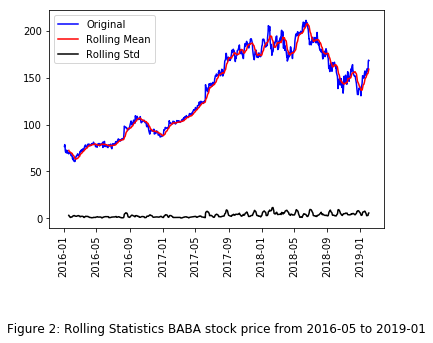

Results of Dickey-Fuller Test:
Test Statistic                  -1.325210
p-value                          0.617561
#Lags Used                      11.000000
Number of Observations Used    764.000000
Critical Value (1%)             -3.438938
Critical Value (5%)             -2.865330
Critical Value (10%)            -2.568788
dtype: float64


In [12]:

test_stationarity(price)

Rolling Mean Removed

In [ ]:
moving_avg = air_pop.rolling(12).mean()
no_trend = air_pop - moving_avg
plt.plot(no_trend)
plt.title("Passenger Data with Rolling Mean Removed")
test_stationarity(no_trend.dropna())